### TimeSeries Analysis
1. A time series forecasting on Revenue generated by top 3 e-stores. From the Top N analysis, the e-stores identified are 1,31,4,30,17. This analysis can be extended to different geographies and the top 3 e-stores in each country as well. But for the moment, it is restricted to only the top 3. For the revenue calculation, we have removed rows where quantity is negative i.e., >= 0
2. An additional forecasting exercise where we forecast the number of invoices. It is helpful in the sense that when there are data quality issues( here quantities being -ve) we can forecast number of invoices which are indirectly orders for each e-store. In this case we will focus on the top 3 e-stores as mentioned above.

In [196]:
###Importing Libraries required
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import warnings
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot

# load dataset
def parser(x):
    return dt.strptime('190'+x, '%Y-%m')

In [2]:
###Path for the url at which the data is saved
csv_url = "https://raw.githubusercontent.com/rohithmadupu/DevoTeam_Assignment/main/ecommerce_data.csv"

In [22]:
###reading the csv and displaying head
df_ecomm = pd.read_csv(csv_url)
df_ecomm.head()

,InvoiceDate,InvoiceNo,StockCode,Description,Quantity,InvoiceDate.1,UnitPrice,CustomerID,Country,Estore_id
0,2010-12-09 15:43:00,C538124,22699,ROSES REGENCY TEACUP AND SAUCER,-1.0,2010-12-09 15:43:00,2.95,15329.0,United Kingdom,20
1,2011-12-09 09:07:00,581480,23355,HOT WATER BOTTLE KEEP CALM,12.0,2011-12-09 09:07:00,4.95,14441.0,United Kingdom,20
2,2011-12-07 12:55:00,581132,NaN,NaN,4.0,2011-12-07 12:55:00,4.95,17590.0,United Kingdom,1
3,2011-06-23 14:11:00,557892,NaN,NaN,2.0,2011-06-23 14:11:00,6.35,14534.0,United Kingdom,17
4,2011-01-25 14:01:00,542115,84992,NaN,1.0,2011-01-25 14:01:00,2.08,NaN,United Kingdom,6


In [4]:
###Getting schema of the dataframe imported
df_ecomm.dtypes

InvoiceDate       object
InvoiceNo         object
StockCode         object
Description       object
Quantity         float64
InvoiceDate.1     object
UnitPrice        float64
CustomerID       float64
Country           object
Estore_id          int64
dtype: object

In [23]:
##Converting customer Id and estore ID to string
###for customerid  -> also removing .0 at the end
df_ecomm["CustomerID"] = df_ecomm["CustomerID"].astype("str")
df_ecomm["CustomerID"] = df_ecomm["CustomerID"].str.replace('.0', '')
df_ecomm["Estore_id"] = df_ecomm["Estore_id"].astype("str")

<ipython-input-23-09c73c345d9e>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df_ecomm["CustomerID"] = df_ecomm["CustomerID"].str.replace('.0', '')


In [24]:
####Checking if both Invoice Dates match and then removing one
if (df_ecomm['InvoiceDate'].equals(df_ecomm['InvoiceDate.1']) == True):
    df_ecomm = df_ecomm.drop(["InvoiceDate.1"], axis = 1)
    
###creating a datefield
df_ecomm['Date'] = pd.to_datetime(df_ecomm.InvoiceDate,errors='coerce').dt.date

df_ecomm['Year'] = pd.to_datetime(df_ecomm.InvoiceDate,errors='coerce').dt.year


In [41]:
###Creating a timeseries for revenue 
###removing the instances where quantities are null and zeroes as nulls will be generated
df_ecomm_new = df_ecomm[df_ecomm['Quantity'] >= 0]
df_ecomm_new["Revenue"] = df_ecomm_new.Quantity * df_ecomm_new.UnitPrice


<ipython-input-41-c4b44d279f51>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ecomm_new["Revenue"] = df_ecomm_new.Quantity * df_ecomm_new.UnitPrice


In [224]:
####Grouping and aggregating revenue by date and e-stores
df_ecomm_series = df_ecomm_new.groupby(["Date","Estore_id"]).agg({'Revenue': 'sum'}).reset_index()

###Forecasting data using last 3 months of data
df_ecomm_series = df_ecomm_series[df_ecomm_series.Date >= dt.date(2011,9,9)]

In [242]:
####Grouping and aggregating transactions by date and e-stores
df_trans_series = pd.DataFrame(df_ecomm.groupby(["Date","Estore_id"]).size().rename('Transaction_Count').reset_index())

###Forecasting data using last 1 months of data
df_trans_series = df_trans_series[df_trans_series.Date >= dt.date(2011,11,9)]


In [237]:
##Function for ARIMA forecasting, currently with order 1,1,1 with train,test split at 80:20
def forecast_revenue(df_ecomm_series,estore_id):
    df_estore1 = pd.DataFrame(df_ecomm_series[df_ecomm_series.Estore_id == str(estore_id)][["Date","Revenue"]])
    df_estore1.index = df_estore1.Date
    df_estore1 = df_estore1[["Revenue"]]

    X = df_estore1.values
    # split into train and test sets
    size = int(len(X) * 0.8)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()

    # walk-forward validation
    for t in range(len(test)):
        model = ARIMA(history, order=(1,1,1))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
    # evaluate forecasts
    rmse = sqrt(mean_squared_error(test, predictions))
    return(rmse,test,predictions)

##Function for ARIMA forecasting, currently with order 1,1,1 with train,test split at 70:30
def forecast_transactions(df_ecomm_series,estore_id):
    df_estore1 = pd.DataFrame(df_ecomm_series[df_ecomm_series.Estore_id == str(estore_id)][["Date","Transaction_Count"]])
    df_estore1.index = df_estore1.Date
    df_estore1 = df_estore1[["Transaction_Count"]]

    X = df_estore1.values
    # split into train and test sets
    size = int(len(X) * 0.7)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()

    # walk-forward validation
    for t in range(len(test)):
        model = ARIMA(history, order=(1,1,1))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
    # evaluate forecasts
    rmse = sqrt(mean_squared_error(test, predictions))
    return(rmse,test,predictions)

predicted=307.632603, expected=21.900000
predicted=288.035678, expected=25.350000
predicted=269.685800, expected=5.400000
predicted=251.970259, expected=152.580000
predicted=241.442012, expected=112.800000
predicted=235.760737, expected=20.210000
predicted=225.057905, expected=4.680000
predicted=210.741379, expected=94.250000
predicted=200.596394, expected=135.290000
predicted=195.970315, expected=25.200000
predicted=188.778088, expected=32.550000
predicted=178.448663, expected=9.940000
Test RMSE: 191.86576345288714


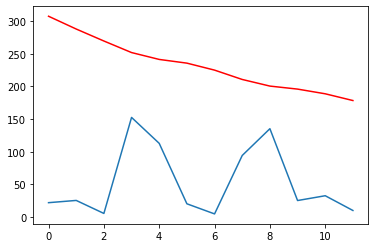

In [217]:
##Top 3 Estores are 1,31,4
###Forecasting Revenue for e-storeid 1
rmse_estore1,test_estore1,predictions_estore1 = forecast_revenue(df_ecomm_series,1)

print(f"Test RMSE: {rmse_estore1}")
# plot forecasts against actual outcomes
pyplot.plot(test_estore1)
pyplot.plot(predictions_estore1, color='red')
pyplot.show()

predicted=55.936582, expected=42.790000
predicted=53.653607, expected=60.430000
predicted=52.965484, expected=67.540000
predicted=52.977116, expected=48.630000
predicted=51.622441, expected=79.920000
predicted=52.547024, expected=73.020000
predicted=53.114742, expected=5.040000
predicted=48.850312, expected=40.450000
predicted=46.900255, expected=33.650000
predicted=44.854016, expected=39.680000
predicted=43.294650, expected=1.100000
predicted=39.387116, expected=92.610000
Test RMSE: 27.183190614802747


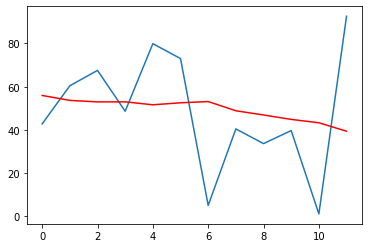

In [219]:
##Top 3 Estores are 1,31,4
###Forecasting Revenue for e-storeid 31
rmse_estore1,test_estore1,predictions_estore1 = forecast_revenue(df_ecomm_series,31)

print(f"Test RMSE: {rmse_estore1}")
# plot forecasts against actual outcomes
pyplot.plot(test_estore1)
pyplot.plot(predictions_estore1, color='red')
pyplot.show()

predicted=-56.017733, expected=4.950000
predicted=-48.369286, expected=9.170000
predicted=-49.658030, expected=1.450000
predicted=-50.545064, expected=49.560000
predicted=-51.980954, expected=17.850000
predicted=-49.016008, expected=39.600000
predicted=-48.914811, expected=81.210000
predicted=-46.947996, expected=116.400000
predicted=-41.345977, expected=24.510000
predicted=-33.500054, expected=33.120000
predicted=-33.331343, expected=16.500000
Test RMSE: 89.06763816560242


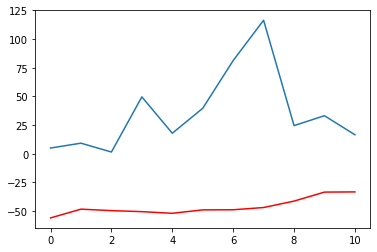

In [220]:
##Top 3 Estores are 1,31,4
###Forecasting Revenue for e-storeid 4
rmse_estore1,test_estore1,predictions_estore1 = forecast_revenue(df_ecomm_series,4)

print(f"Test RMSE: {rmse_estore1}")
# plot forecasts against actual outcomes
pyplot.plot(test_estore1)
pyplot.plot(predictions_estore1, color='red')
pyplot.show()

predicted=16.811096, expected=25.000000
predicted=16.502232, expected=2.000000
predicted=17.876534, expected=17.000000
predicted=14.078845, expected=5.000000
predicted=14.598309, expected=17.000000
predicted=11.642766, expected=21.000000
predicted=11.790947, expected=35.000000
predicted=13.861019, expected=8.000000
predicted=16.777251, expected=28.000000
Test RMSE: 11.317903033144953


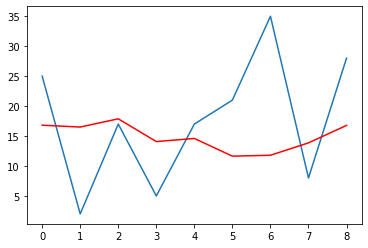

In [238]:
##Top 3 Estores are 1,31,4
###Forecasting transactions for e-storeid 1
rmse_estore1,test_estore1,predictions_estore1 = forecast_transactions(df_trans_series,1)

print(f"Test RMSE: {rmse_estore1}")
# plot forecasts against actual outcomes
pyplot.plot(test_estore1)
pyplot.plot(predictions_estore1, color='red')
pyplot.show()

predicted=20.572286, expected=43.000000
predicted=33.242263, expected=8.000000
predicted=23.337395, expected=24.000000
predicted=25.092735, expected=8.000000
predicted=21.134418, expected=20.000000
predicted=21.997219, expected=24.000000
predicted=22.848740, expected=28.000000
predicted=24.198444, expected=5.000000
predicted=20.042298, expected=23.000000
Test RMSE: 14.305929602097565


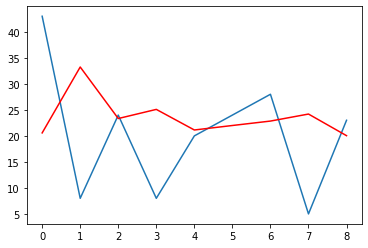

In [240]:
##Top 3 Estores are 1,31,4
###Forecasting transactions for e-storeid 31
rmse_estore1,test_estore1,predictions_estore1 = forecast_transactions(df_trans_series,31)

print(f"Test RMSE: {rmse_estore1}")
# plot forecasts against actual outcomes
pyplot.plot(test_estore1)
pyplot.plot(predictions_estore1, color='red')
pyplot.show()

predicted=9.114572, expected=39.000000
predicted=21.492648, expected=6.000000
predicted=20.566256, expected=18.000000
predicted=18.510041, expected=7.000000
predicted=17.277465, expected=14.000000
predicted=15.485104, expected=26.000000
predicted=15.447291, expected=29.000000
predicted=17.373289, expected=9.000000
predicted=17.480906, expected=20.000000
Test RMSE: 13.555098269756813


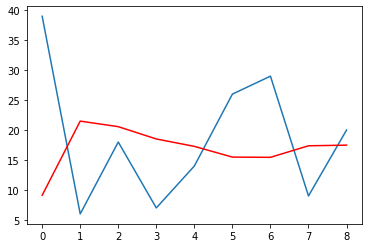

In [241]:
##Top 3 Estores are 1,31,4
###Forecasting transactions for e-storeid 31
rmse_estore1,test_estore1,predictions_estore1 = forecast_transactions(df_trans_series,4)

print(f"Test RMSE: {rmse_estore1}")
# plot forecasts against actual outcomes
pyplot.plot(test_estore1)
pyplot.plot(predictions_estore1, color='red')
pyplot.show()